In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split


from scipy import optimize
from scipy.io import loadmat

import numba 
from numba import prange

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from scipy.spatial import procrustes
from matplotlib.colors import ListedColormap


d = loadmat('data/macosko.mat')

X_data = d['X_data']
y_data = d['y_data'].reshape(-1)

print(X_data.shape,y_data)

#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.33, random_state=42)

X_train = X_data
y_train = y_data

n = X_train.shape[0]

classes = ['Amacrine cells',
           'Astrocytes',
           'Bipolar cells',
           'Cones',
           'Fibroblasts',
           'Horizontal cells',
           'Microglia',
           'Muller glia',
           'Pericytes',
           'Retinal ganglion cells',
           'Rods',
           'Vascular endothelium']
    
print(X_train.shape, y_train.shape, X_train.dtype)
#print(X_test.shape, y_test.shape, X_test.dtype)

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(44808, 50) [ 9.  9.  9. ...  9. 10. 10.]
(44808, 50) (44808,) float32


In [2]:
import numba
from numba import prange

#@numba.jit(nopython=True)
def map_rotate(y, rot_angle):
    theta = (rot_angle) * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    Y = y
    Y = rot_mat.dot(Y.T).T
    
    return Y

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val


In [3]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nB = 17404
nC = 17404

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]
SETB = X_train_rp[nA:nA+nB]
y_SETB = y_train_rp[nA:nA+nB]
SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC = y_train_rp[nA+nB:nA+nB+nC]

data1 = np.concatenate((SETA, SETB))
data2 = np.concatenate((SETA, SETC))


print(SETA.shape, SETB.shape, SETC.shape)

(10000, 50) (17404, 50) (17404, 50)


In [4]:
Com_set = np.concatenate((SETA,SETB,SETC))
y_com_set = np.concatenate((y_SETA, y_SETB, y_SETC))

sort_idx, dist = get_first_order_graph(Com_set,n_neighbors=Com_set.shape[0]-1)

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Completed  10000  of  44808
Completed  20000  of  44808
Completed  30000  of  44808
Completed  40000  of  44808


In [5]:
with open('MACOSKO_Aligned_NE.npy', 'rb') as f:
    embA_ne = np.load(f)
    embB_ne = np.load(f)
    embC_ne = np.load(f)

In [6]:
k_nn=5
T1_ne = my_trustworthiness(np.concatenate((embA_ne,embB_ne,embC_ne)),sort_idx,k_nn)

print(T1_ne)

0.9446324504393349


<IPython.core.display.Javascript object>


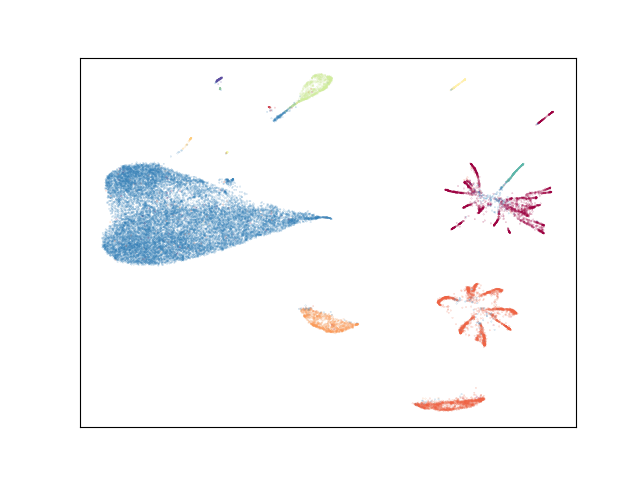

<IPython.core.display.Javascript object>


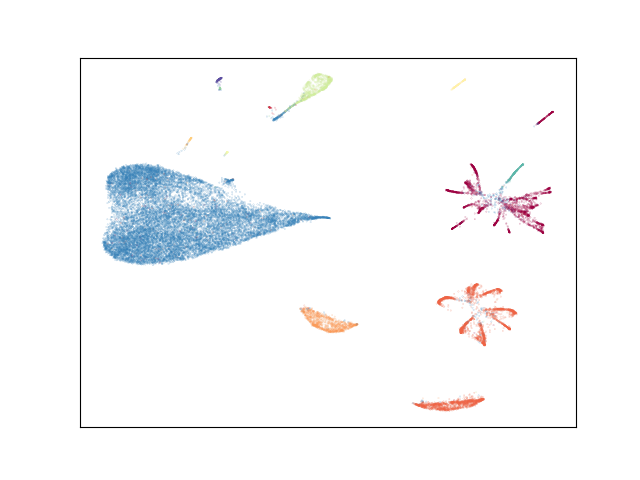

In [7]:
emb_set1 = np.concatenate((embA_ne, embB_ne))
#emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA, y_SETB))

embA_rot = embA_ne #map_rotate(embA_ne, rot_angle=40)

fig = plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.45, 11.2])
plt.ylim([-12.10, 9.45])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne10k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne, embC_ne))
#emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA,y_SETC))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot[:,0], -embA_rot[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.45, 11.2])
plt.ylim([-12.10, 9.45])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne10k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

In [8]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 5000
nB = int((len(X_train_rp)-nA)/2)
nC = nB

#SETA = X_train_rp[:nA]
y_SETA_ne5 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne5 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne5 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)


with open('MACOSKO_Aligned_NE_5k.npy', 'rb') as f:
    embA_ne5 = np.load(f)
    embB_ne5 = np.load(f)
    embC_ne5 = np.load(f)

In [9]:
T1_ne5 = my_trustworthiness(np.concatenate((embA_ne5,embB_ne5,embC_ne5)),sort_idx,k_nn)

print(T1_ne5)

0.9439570278625309


<IPython.core.display.Javascript object>


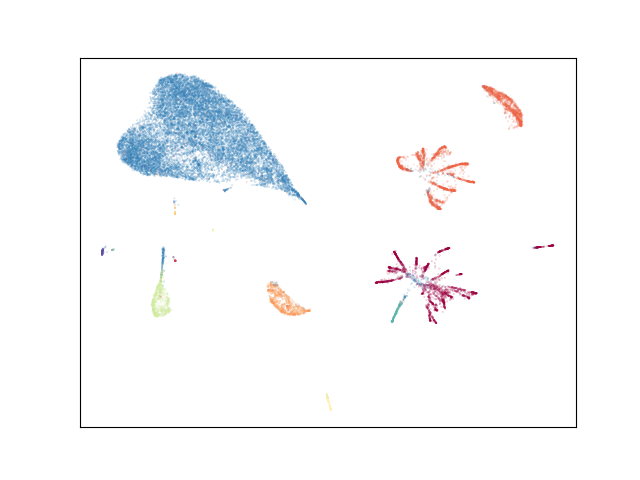

<IPython.core.display.Javascript object>


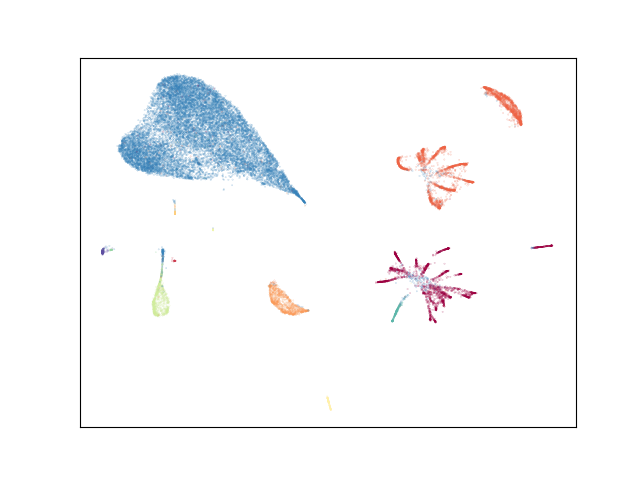

<IPython.core.display.Javascript object>


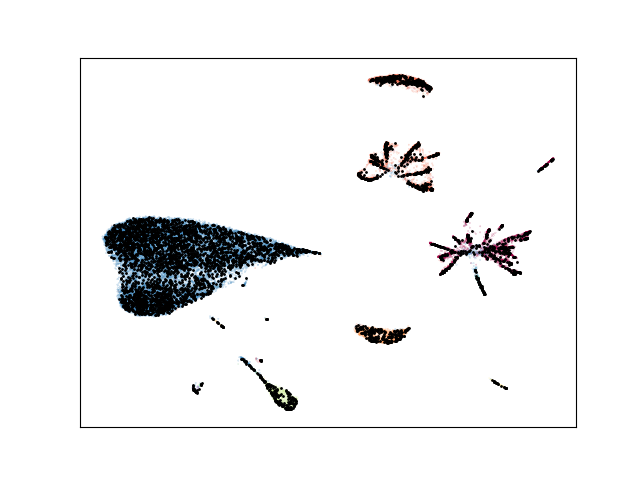

([], [])

In [10]:
emb_set1 = np.concatenate((embA_ne5, embB_ne5))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne5, y_SETB_ne5))

embA_rot5 = embA_ne5 #map_rotate(embA_ne5, rot_angle=40)



plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')
#plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.45, 13.87])
plt.ylim([-12.8, 7.8])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne5k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne5, embC_ne5))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne5,y_SETC_ne5))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')
#plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.45, 13.87])
plt.ylim([-12.8, 7.8])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne5k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne5, embB_ne5, embC_ne5))
#emb_set = map_rotate(emb_set, rot_angle=40)
y_emb_set = np.concatenate((y_SETA_ne5, y_SETB_ne5, y_SETC_ne5))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')
plt.scatter(embA_rot5[:,0], -embA_rot5[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])



In [11]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 1000
nB = int((len(X_train_rp)-nA)/2)
nC = nB

#SETA = X_train_rp[:nA]
y_SETA_ne1 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne1 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne1 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MACOSKO_Aligned_NE_1k.npy', 'rb') as f:
    embA_ne1 = np.load(f)
    embB_ne1 = np.load(f)
    embC_ne1 = np.load(f)

In [12]:
T1_ne1 = my_trustworthiness(np.concatenate((embA_ne1,embB_ne1,embC_ne1)),sort_idx,k_nn)

print(T1_ne1)

0.9431053089411648


<IPython.core.display.Javascript object>


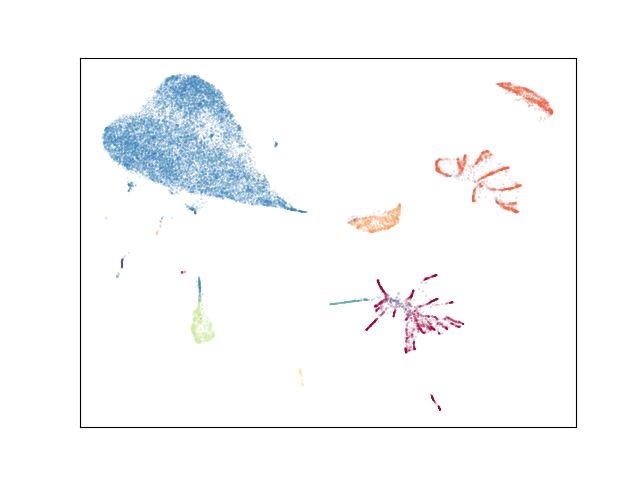

<IPython.core.display.Javascript object>


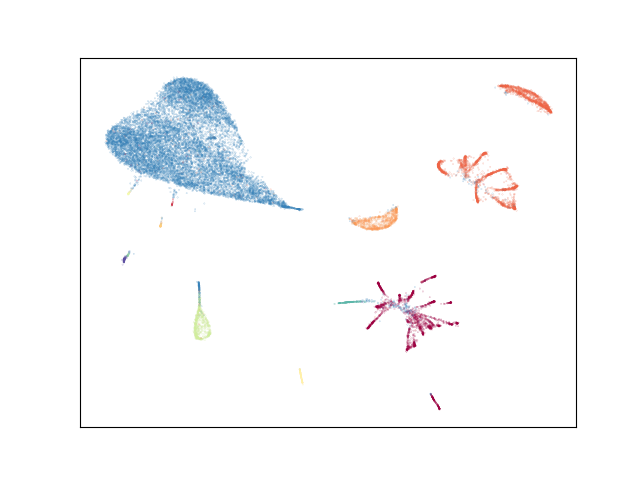

<IPython.core.display.Javascript object>


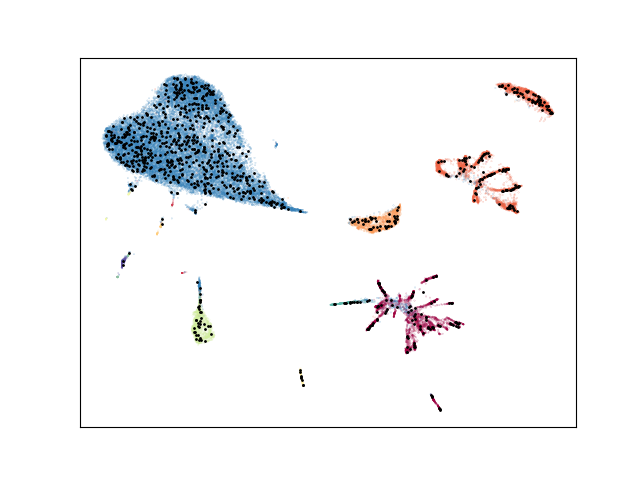

([], [])

In [13]:
emb_set1 = np.concatenate((embA_ne1, embB_ne1))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne1, y_SETB_ne1))

embA_rot1 = map_rotate(embA_ne1, rot_angle=40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.15, 12.4])
plt.ylim([-12.8, 7.55])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne1k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne1, embC_ne1))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne1,y_SETC_ne1))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-9.15, 12.4])
plt.ylim([-12.8, 7.55])



#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne1k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne1, embB_ne1, embC_ne1))
emb_set = map_rotate(emb_set, rot_angle=40)
y_emb_set = np.concatenate((y_SETA_ne1, y_SETB_ne1, y_SETC_ne1))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot1[:,0], -embA_rot1[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

In [14]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 100
nB = int((len(X_train_rp)-nA)/2)
nC = nB

#SETA = X_train_rp[:nA]
y_SETA_ne100 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne100 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne100 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MACOSKO_Aligned_NE_100.npy', 'rb') as f:
    embA_ne100 = np.load(f)
    embB_ne100 = np.load(f)
    embC_ne100 = np.load(f)

In [15]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne100,embB_ne100,embC_ne100)),sort_idx,k_nn)

print(T1_ne100)

0.9402406671241743


<IPython.core.display.Javascript object>


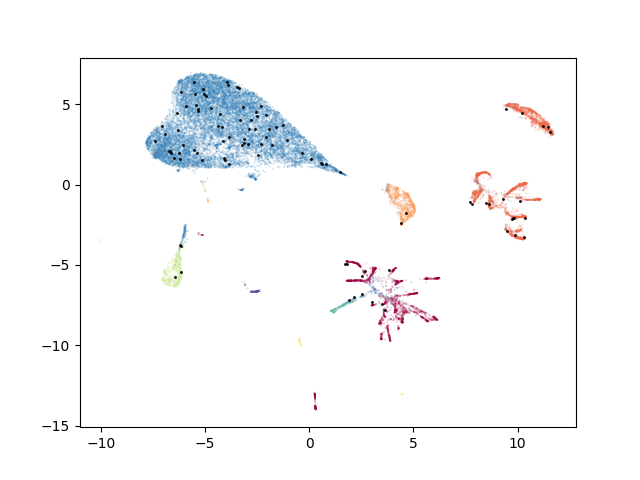

<IPython.core.display.Javascript object>


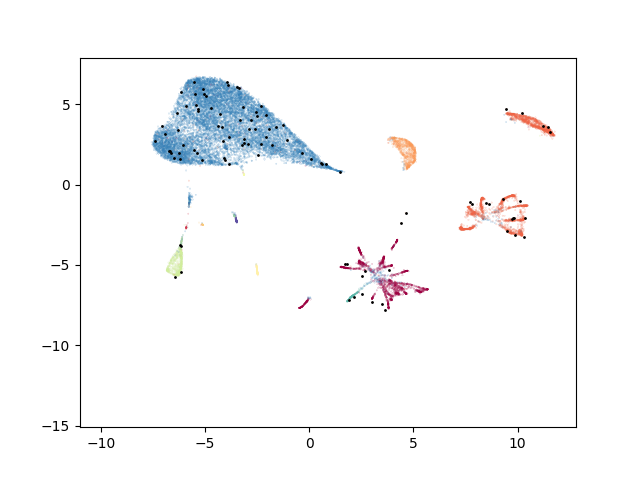

<IPython.core.display.Javascript object>


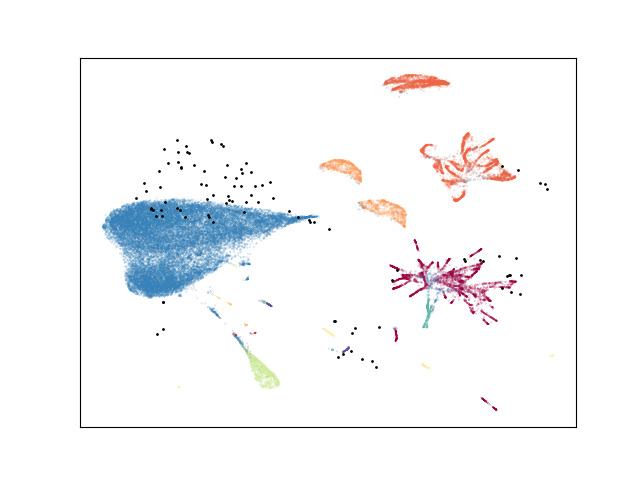

([], [])

In [16]:
emb_set1 = np.concatenate((embA_ne100, embB_ne100))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne100, y_SETB_ne100))

embA_rot100 = map_rotate(embA_ne100, rot_angle=40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
#plt.xticks([],[])
#plt.yticks([],[])

plt.xlim([-11.0, 12.8])
plt.ylim([-15.10, 7.9])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne100_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne100, embC_ne100))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne100, y_SETC_ne100))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
#plt.xticks([],[])
#plt.yticks([],[])

plt.xlim([-11.0, 12.8])
plt.ylim([-15.10, 7.9])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne100_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne100, embB_ne100, embC_ne100))
#emb_set = map_rotate(emb_set, rot_angle=40)

y_emb_set = np.concatenate((y_SETA_ne100, y_SETB_ne100, y_SETC_ne100))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


In [17]:
#np.random.seed(23423)

#rand_perm = np.random.permutation(n)

#X_train_rp = X_train[rand_perm]
#y_train_rp = y_train[rand_perm]

nA = 20000
nB = int((len(X_train_rp)-nA)/2)
nC = nB

#SETA = X_train_rp[:nA]
y_SETA_ne20 = y_train_rp[:nA]
#SETB = X_train_rp[nA:nA+nB]
y_SETB_ne20 = y_train_rp[nA:nA+nB]
#SETC = X_train_rp[nA+nB:nA+nB+nC]
y_SETC_ne20 = y_train_rp[nA+nB:nA+nB+nC]

#data1 = np.concatenate((SETA, SETB))
#data2 = np.concatenate((SETA, SETC))


#print(SETA.shape, SETB.shape, SETC.shape)

with open('MACOSKO_Aligned_NE_20K.npy', 'rb') as f:
    embA_ne20 = np.load(f)
    embB_ne20 = np.load(f)
    embC_ne20 = np.load(f)

In [18]:
T1_ne100 = my_trustworthiness(np.concatenate((embA_ne20,embB_ne20,embC_ne20)),sort_idx,k_nn)

print(T1_ne100)

0.9469397061390504


<IPython.core.display.Javascript object>


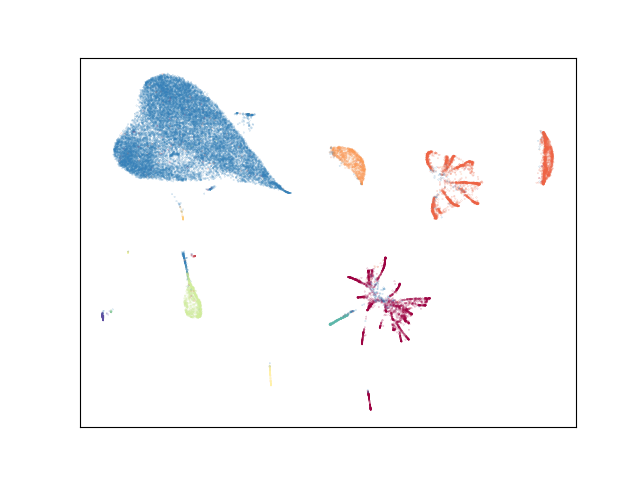

<IPython.core.display.Javascript object>


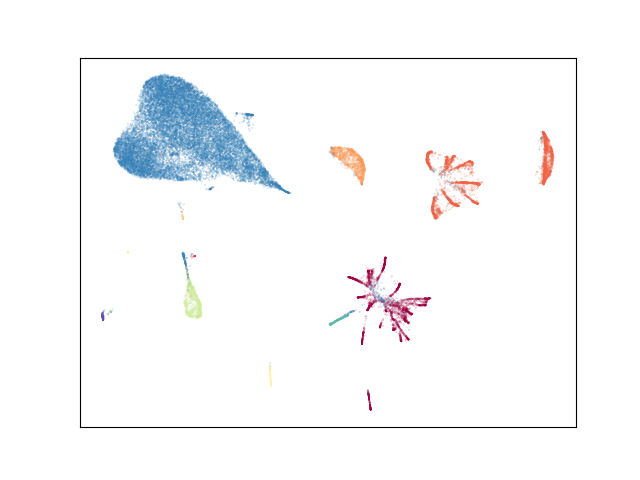

<IPython.core.display.Javascript object>


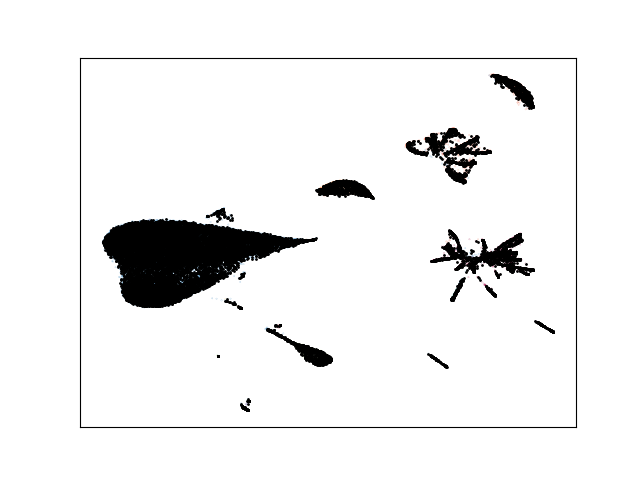

([], [])

In [19]:
emb_set1 = np.concatenate((embA_ne20, embB_ne20))
emb_set1 = map_rotate(emb_set1, rot_angle=40)
y_emb_set1 = np.concatenate((y_SETA_ne20, y_SETB_ne20))

embA_rot20 = embA_ne20 #map_rotate(embA_ne100, rot_angle=40)

plt.figure()
#plt.title('EM_SET_1')
plt.scatter(emb_set1[:,0], -emb_set1[:,1], c=y_emb_set1, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.75, 15.65])
plt.ylim([-12.75, 7.6])

#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne20k_umap_1.png', dpi=fig.dpi, bbox_inches='tight')

emb_set2 = np.concatenate((embA_ne20, embC_ne20))
emb_set2 = map_rotate(emb_set2, rot_angle=40)
y_emb_set2 = np.concatenate((y_SETA_ne20, y_SETC_ne20))


plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set2[:,0], -emb_set2[:,1], c=y_emb_set2, s=0.01, cmap='Spectral')

#plt.scatter(embA_rot100[:,0], -embA_rot100[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])

plt.xlim([-10.75, 15.65])
plt.ylim([-12.75, 7.6])


#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

plt.savefig('macosko_figures/ne20k_umap_2.png', dpi=fig.dpi, bbox_inches='tight')

emb_set = np.concatenate((embA_ne20, embB_ne20, embC_ne20))
#emb_set = map_rotate(emb_set, rot_angle=40)

y_emb_set = np.concatenate((y_SETA_ne20, y_SETB_ne20, y_SETC_ne20))

plt.figure()
#plt.title('EM_SET_2')
plt.scatter(emb_set[:,0], -emb_set[:,1], c=y_emb_set, s=0.01, cmap='Spectral')

plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
plt.xticks([],[])
plt.yticks([],[])


In [20]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3008
nRest = 8360


SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

with open('MACOSKO_Aligned_NE_5_SETS_3000_11400.npy', 'rb') as f:
    embA_5s = np.load(f)
    emB_sets = np.load(f)

in loop
in loop
in loop
in loop
in loop
out of loop
(3008, 50) (5, 8360, 50) (8360, 50) (5, 11368, 50) 5


<IPython.core.display.Javascript object>


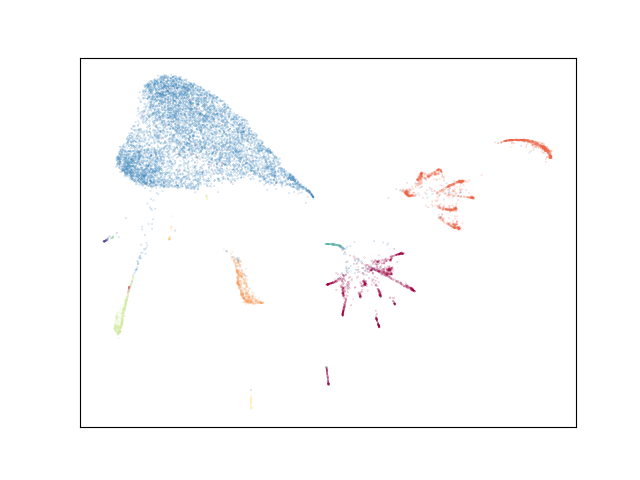

<IPython.core.display.Javascript object>


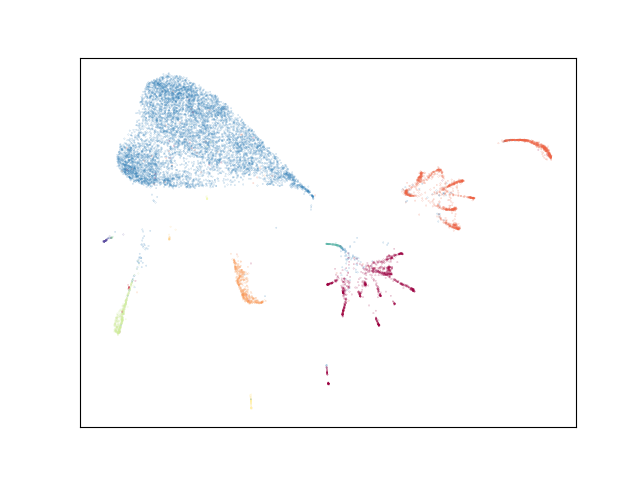

<IPython.core.display.Javascript object>


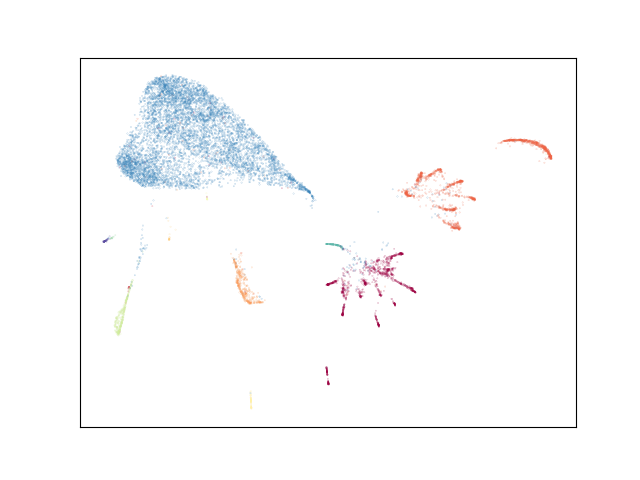

<IPython.core.display.Javascript object>


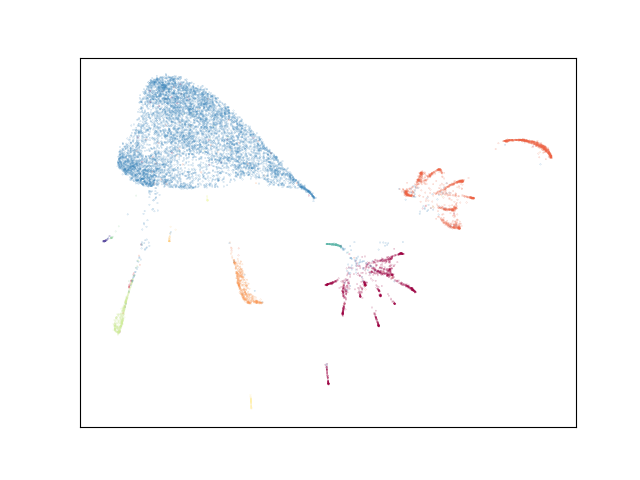

<IPython.core.display.Javascript object>


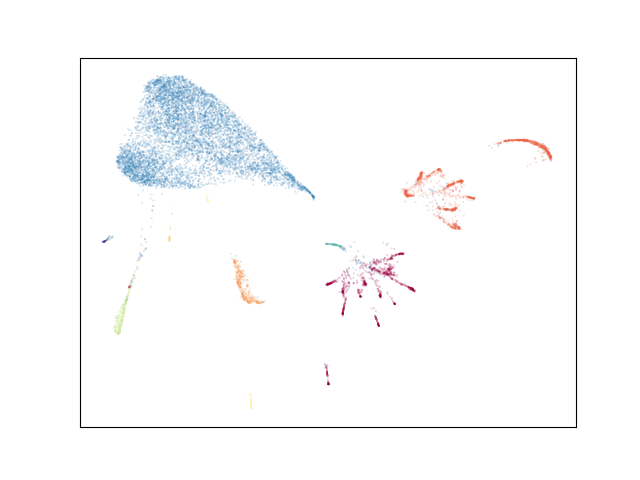

In [21]:

for i in range(len(emB_sets)):
    emb_set_ns5 = np.concatenate((embA_5s, emB_sets[i]))
    emb_set_ns5 = map_rotate(emb_set_ns5, rot_angle=40)
    y_emb_set_ns5 = np.concatenate((y_SETA, y_SETS[i]))

    #embA_rot20 = embA_ne20 #map_rotate(embA_ne100, rot_angle=40)

    plt.figure()
    #plt.title('EM_SET_1')
    plt.scatter(emb_set_ns5[:,0], -emb_set_ns5[:,1], c=y_emb_set_ns5, s=0.01, cmap='Spectral')

    #plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
    plt.xticks([],[])
    plt.yticks([],[])

    plt.xlim([-4.4, 6.85])
    plt.ylim([-5.40, 3.35])

    #cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    #cbar.set_ticks(np.arange(10))
    #cbar.set_ticklabels(classes)

    plt.savefig('macosko_figures/ne_umap5split_'+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')

in loop
in loop
in loop
in loop
in loop
out of loop
(3008, 50) (5, 8360, 50) (8360, 50) (5, 11368, 50) 5
Completed  10000  of  11368


<IPython.core.display.Javascript object>


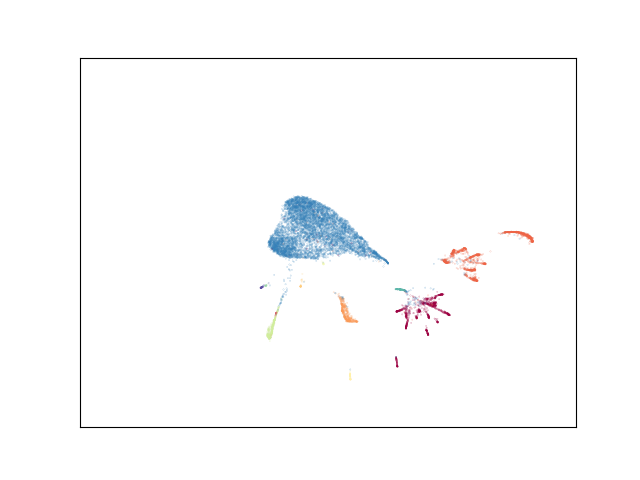

Completed  10000  of  11368


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


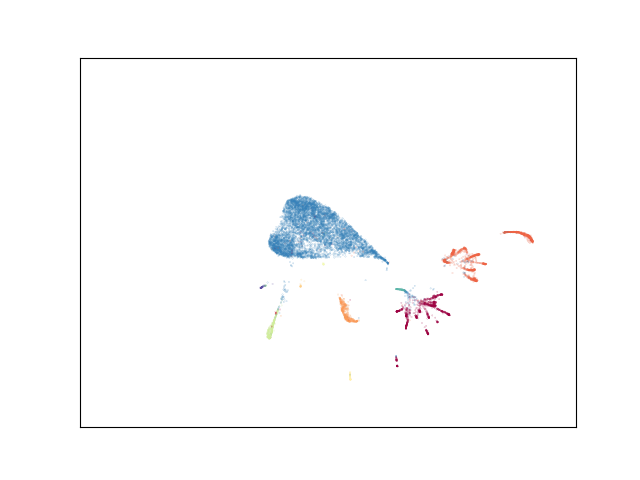

Completed  10000  of  11368


<IPython.core.display.Javascript object>


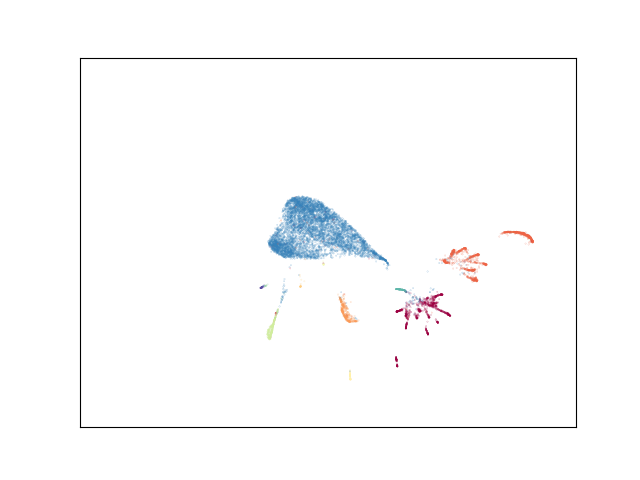

Completed  10000  of  11368


<IPython.core.display.Javascript object>


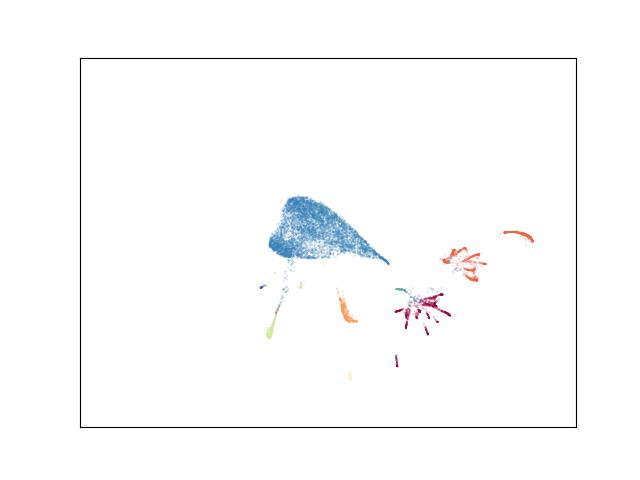

Completed  10000  of  11368


<IPython.core.display.Javascript object>


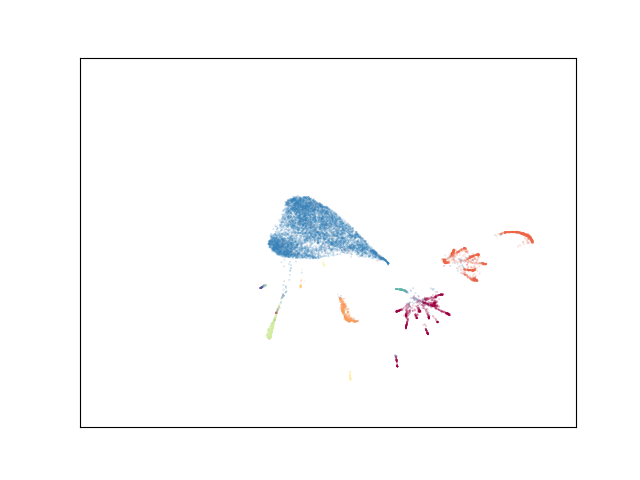

In [24]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 3008
nRest = 8360

SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

with open('MACOKSO_Aligned_NE_5_SETS_3000_11400.npy', 'rb') as f:
    embA_5s = np.load(f)
    emB_sets = np.load(f)

TRST = np.zeros(len(emB_sets))
    
for i in range(len(emB_sets)):
    emb_set_ns5 = np.concatenate((embA_5s, emB_sets[i]))
    emb_set_ns5 = map_rotate(emb_set_ns5, rot_angle=40)
    y_emb_set_ns5 = np.concatenate((y_SETA, y_SETS[i]))
    
    sort_idx_ns5, _ = get_first_order_graph(DATA[i],n_neighbors=DATA[i].shape[0]-1)
    TRST[i] = my_trustworthiness(emb_set_ns5, sort_idx_ns5, k_nn)
    

    #embA_rot20 = embA_ne20 #map_rotate(embA_ne100, rot_angle=40)

    plt.figure()
    #plt.title('EM_SET_1')
    plt.scatter(emb_set_ns5[:,0], -emb_set_ns5[:,1], c=y_emb_set_ns5, s=0.01, cmap='Spectral')

    #plt.scatter(embA_rot20[:,0], -embA_rot20[:,1], c='k', s=1)
    plt.xticks([],[])
    plt.yticks([],[])

    plt.xlim([-10.60, 7.9])
    plt.ylim([-7.00, 8.9])

    #cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    #cbar.set_ticks(np.arange(10))
    #cbar.set_ticklabels(classes)

    plt.savefig('macosko_figures/ne_umap5split_3000_11400_'+str(i)+'.png', dpi=fig.dpi, bbox_inches='tight')
    
    

In [25]:
for i in range(len(emB_sets)):
    print('T', i, ': ', TRST[i])
    
    
total_emb = np.concatenate(emB_sets)
total_emb = np.concatenate((embA_5s, total_emb))

T_5sets = my_trustworthiness(total_emb, sort_idx, 5)

print('Trustworthiness: ', T_5sets)

T 0 :  0.9362032369710876
T 1 :  0.9370549730030429
T 2 :  0.9382906753947329
T 3 :  0.9383438624356979
T 4 :  0.9382470407419888
Trustworthiness:  0.9360734721119635
